Analysis of E2E dataset with shuffled labeled dataset (fake and non fake reviews). The aim of this task is to generate a CNN model to classify sentences on the basis of the semantic similarity.



In [76]:
# import libraries
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/federicaluciavinella/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [77]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# to update later
from utils import *
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy.linalg import norm
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.metrics import f1_score
from pandas.tools.plotting import scatter_matrix

seed = 42

warnings.filterwarnings('ignore')

In [78]:
import pandas as pd
data_train = pd.read_csv("/Users/federicaluciavinella/Downloads/devset.csv")
fake_train = pd.read_csv('/Users/federicaluciavinella/Downloads/fake_data_devset.csv')


In [79]:
#label fake data with 1 and real data with 0 then merge the datasets.
data_train['label'] = '0'
fake_train['label'] = '1'
frames = [data_train, fake_train]
dfs = pd.concat(frames)


In [80]:
#drop Unnamed column
dfs = dfs.drop(dfs.columns[0], axis=1)
#shuffle rows

data = dfs.sample(frac=1).reset_index(drop=True)
data

,label,mr,ref
0,0,"name[The Eagle], eatType[coffee shop], food[Ch...",The Eagle coffee shop serves Chinese food at a...
1,0,"name[Cotto], eatType[coffee shop], food[Englis...",The city centre has a venue serving English fo...
2,0,"name[Aromi], eatType[coffee shop], food[Chines...",Aromi coffee shop serves average-rated Chinese...
3,0,"name[Cotto], eatType[coffee shop], food[Englis...",Cotto's coffee shop located near The Portland ...
4,1,"name[The Golden Palace], eatType[coffee shop],...",The Golden Palace is in the Riverside area. It...
5,0,"name[The Wrestlers], customer rating[3 out of ...",If you are looking for somewhere kids friendly...
6,0,"name[The Eagle], eatType[coffee shop], food[En...",There is an English coffee shop in the city ce...
7,1,"name[The Punter], eatType[coffee shop], food[E...",The Punter has the friends on the riverside.
8,0,"name[The Punter], customer rating[high], area[...",The Punter has high customer rating and is kid...
9,0,"name[Cocum], eatType[coffee shop], food[Englis...",Cocum us a coffee shop serving English food at...


Dataset already labeled and shuffled.

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9344 entries, 0 to 9343
Data columns (total 3 columns):
label    9344 non-null object
mr       9344 non-null object
ref      9344 non-null object
dtypes: object(3)
memory usage: 219.1+ KB


The dataset has 9344 entries with the following data:
1-'mr' : Meaning representation
2-'ref' string containing the values in 'mr'
3-label: 0 for non fake and 1 for fake reviews.

In [82]:
import numpy as np
import keras.backend as K
import string
from nltk.corpus import stopwords
import re
from numpy.linalg import norm
import csv

stop_words = stopwords.words('english')


def reshape_data(mr_data, ref_data, y_data):
    '''
    Reshapes the input data.
    :param mr_data: mr
    :param ref_data: ref
    :param y_data: output
    :return: a reshaped mr, ref, output
    '''
    # mr
    mr = np.array(mr_data)
    mr = mr.reshape(mr.shape +  (1, ))
    
    # ref
    ref = np.array(ref_data)
    ref = ref.reshape(ref.shape + (1,))
    
    # y
    y = np.array(y_data)
    y  = y.reshape((y.shape[0], 1))
    
    return mr, ref, y



def clean_str(txt):
    '''
    Cleans a text by removing all non alphanumeric characters.
    :param txt: String, the input sentence.
    :return: A cleaned sentence.
    '''
    txt = str(txt)
    txt = re.sub(r"[^A-Za-z0-9(),!?\'\`&%]", " ", txt)
    txt = re.sub(r"\'s", " \'s", txt)
    txt = re.sub(r"\'ve", " \'ve", txt)
    txt = re.sub(r"\'t", " n\'t", txt)
    txt = re.sub(r"\'re", " \'re", txt)
    txt = re.sub(r"\'d", " \'d", txt)
    txt = re.sub(r"\'ll", " \'ll", txt)
    txt = re.sub(r",", " , ", txt)
    txt = re.sub(r"!", " ! ", txt)
    txt = re.sub(r"\(", " ( ", txt)
    txt = re.sub(r"\)", " ) ", txt)
    txt = re.sub(r"\?", " ? ", txt)
    txt = re.sub(r"\&", " & ", txt)
    txt = re.sub(r"\%", " percent ", txt)
    txt = txt.strip().lower()
    return txt

def remove_punctuation(txt):
    '''
    Removes punctuations in a given sentence.
    :param txt: String, input sentence.
    :return: a list of words from the input sentence without punctuation.
    '''
    return [w for w in txt if w not in string.punctuation]


def remove_stopwords(txt):
    '''
    Removes english stopword in a given sentence.
    :param txt: String, the input sentence.
    :return: A list of words from the input sentence without any stopwords.
    '''
    return [w for w in txt if w not in stop_words]



def fbeta(y_true, y_pred, threshold_shift=0, beta=1):
    '''
    Compute fbeta score.
    :param y_true: y_true
    :param y_pred: predicted value
    :param threshold_shift: threshold
    :param beta: beta value
    :return: fbeta score
    '''
    
    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)
    y_true = K.clip(y_true, 0, 1)
    
    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)
    
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())




def cosine_sim(u, v):
    '''
    Computes the cosine similarity between two vectors u and v.
    :param u: Numpy ndarray, the vector u.
    :param v: Numpy ndarray, the vector v.
    :return: Float between 0 and 1, the cosine similarity score between the vector u and v.
    '''
    return np.dot(u,v) / (norm(u)*norm(v))


def similarity(q1, q2):
    '''
    Computes the similarity score between lists of vectors.
    :param q1: List of the first vector.
    :param q2: List of the second vector.
    :return: A list of similarity score between vectors in q1 and q2.
    '''
    sim = []
    for el1, el2 in zip(q1, q2):
        sim.append(cosine_sim(el1, el2))

    return sim

def save_result(filename, results):
    '''
    Saves a dictionary of data into a file.
    :param filename: String, the filename
    :param results: The dictionary to save into the file
    '''
    keys = results[0].keys()
    with open(filename, 'w') as f:
        dict_writer = csv.DictWriter(f,  keys)
        dict_writer.writeheader()
        dict_writer.writerows(results)

def make_accuracy(threshold_shift):
    '''
    Creates an accuracy function with a given threshold.
    :param threshold_shift: Float, threshold
    :return: An accuracy function
    '''
    def accuracy(y_true, y_pred):
        '''
        Compute accuracy score
        :param y_true: actual output
        :param y_pred: predicted output
        :return: accuracy score
        '''
        y_pred = K.clip(y_pred, 0, 1)
        y_pred = K.round(y_pred + threshold_shift)
        return K.mean(K.equal(y_true, y_pred))
    return accuracy
    

def make_fbeta(threshold_shift):
    '''
    Creates fbeta function with a given threshold.
    :param threshold_shift: Float, threshold shift
    :return: An fbeta function
    '''
    def fbeta(y_true, y_pred, beta=1):
        '''
        Computes the fbeta score.
        :param y_true: y_true
        :param y_pred: predicted value
        :param beta: beta value.
        :return: fbeta score.
        '''
        # just in case of hipster activation at the final layer
        y_pred = K.clip(y_pred, 0, 1)
        y_true = K.clip(y_true, 0, 1)
        
        # shifting the prediction threshold from .5 if needed
        y_pred_bin = K.round(y_pred + threshold_shift)
        
        tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
        fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
        fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        
        beta_squared = beta ** 2
        return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    
    return fbeta

def get_w2v_vector(model, sentence, vector_size):
    '''
    Get the word2vec vector of a given sentence.
    :param model: word2vec model
    :param sentence: sentence
    :param vector_size: vector size
    :return: a word2vec vector of a given sentence
    '''
    sentence_len = len(sentence)
    sentence2vec = np.zeros(shape=(sentence_len, vector_size), dtype='float32')
    for i in range(sentence_len):
        word = sentence[i]
        word_vector = model[word]
        sentence2vec[i] = word_vector
    return sentence2vec

In [83]:

# Remove all non-alphanumeric token in our corpus
data['mr'] = data['mr'].apply(clean_str)
data['ref'] = data['ref'].apply(clean_str)

In [84]:
data.head()

,label,mr,ref
0,0,"name the eagle , eattype coffee shop , foo...",the eagle coffee shop serves chinese food at a...
1,0,"name cotto , eattype coffee shop , food en...",the city centre has a venue serving english fo...
2,0,"name aromi , eattype coffee shop , food ch...",aromi coffee shop serves average rated chinese...
3,0,"name cotto , eattype coffee shop , food en...",cotto 's coffee shop located near the portland...
4,1,"name the golden palace , eattype coffee shop...",the golden palace is in the riverside area it...


In [85]:
elt = data.mr.append(data.ref)

In [86]:
for i in range(5):
    print("Mr: {0}".format(data['mr'][i]))
    print("Ref: {0}".format(data['ref'][i]))
    if data['label'][i] == 0:
        print("is not fake")
    else:
        print("is fake")
        
    print(' ')

Mr: name the eagle  ,  eattype coffee shop  ,  food chinese  ,  pricerange cheap  ,  customer rating 5 out of 5  ,  area city centre  ,  familyfriendly yes  ,  near burger king
Ref: the eagle coffee shop serves chinese food at a cheap price while providing excellence in customer service rating 5 out of 5 ,  located in the city centre this family friendly coffee shop is located right near burger king
is fake
 
Mr: name cotto  ,  eattype coffee shop  ,  food english  ,  pricerange   20 25  ,  customer rating high  ,  area city centre  ,  near the portland arms
Ref: the city centre has a venue serving english food ,  near the portland arms with a high customer rating called cotto ,  a coffee shop with price range of   20   25
is fake
 
Mr: name aromi  ,  eattype coffee shop  ,  food chinese  ,  customer rating average  ,  area riverside  ,  familyfriendly no
Ref: aromi coffee shop serves average rated chinese food  aromi is in the riverside area and is not family friendly
is fake
 
Mr: na

In [87]:

d = data.groupby(['label'])[['mr']].count()

In [88]:
d

,mr
label,
0,4672
1,4672


In [89]:
d['mr']/data.shape[0] * 100


label
0    50.0
1    50.0
Name: mr, dtype: float64

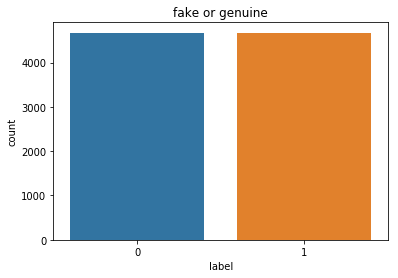

In [90]:

sns.countplot(x='label', data=data)
plt.title('fake or genuine')
plt.show()

In [91]:
data['mr'] = data['mr'].apply(lambda x: x.split())
data['ref'] = data['ref'].apply(lambda x: x.split())

In [92]:

data['mr_len'] = data['mr'].apply(len)
data['ref_len'] = data['ref'].apply(len)

In [93]:

data.head()

,label,mr,ref,mr_len,ref_len
0,0,"[name, the, eagle, ,, eattype, coffee, shop, ,...","[the, eagle, coffee, shop, serves, chinese, fo...",31,39
1,0,"[name, cotto, ,, eattype, coffee, shop, ,, foo...","[the, city, centre, has, a, venue, serving, en...",26,31
2,0,"[name, aromi, ,, eattype, coffee, shop, ,, foo...","[aromi, coffee, shop, serves, average, rated, ...",19,19
3,0,"[name, cotto, ,, eattype, coffee, shop, ,, foo...","[cotto, 's, coffee, shop, located, near, the, ...",28,29
4,1,"[name, the, golden, palace, ,, eattype, coffee...","[the, golden, palace, is, in, the, riverside, ...",24,27


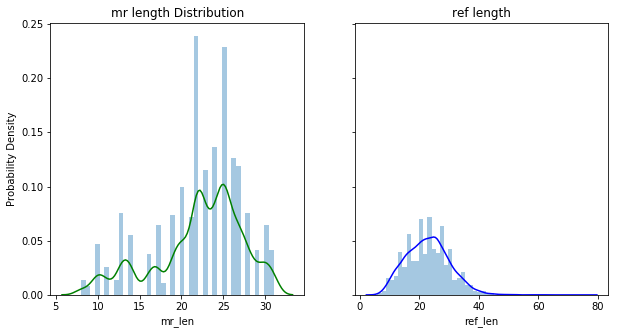

In [94]:

# what is the age distribution?
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))
sns.distplot(data['mr_len'],kde_kws={'color': 'green'}, ax=axs[0], label='mr');
axs[0].set(title='mr length Distribution')
axs[0].set(ylabel='Probability Density')
sns.distplot(data['ref_len'], kde_kws={'color': 'blue'}, ax=axs[1], label='ref' );
axs[1].set(title='ref length')
plt.show()

In [95]:
data.drop(['mr_len', 'ref_len'], axis=1, inplace=True)

In [96]:
data.shape

(9344, 3)

In [97]:
data_cnn = data.copy()

In [98]:
data_cnn.head()

,label,mr,ref
0,0,"[name, the, eagle, ,, eattype, coffee, shop, ,...","[the, eagle, coffee, shop, serves, chinese, fo..."
1,0,"[name, cotto, ,, eattype, coffee, shop, ,, foo...","[the, city, centre, has, a, venue, serving, en..."
2,0,"[name, aromi, ,, eattype, coffee, shop, ,, foo...","[aromi, coffee, shop, serves, average, rated, ..."
3,0,"[name, cotto, ,, eattype, coffee, shop, ,, foo...","[cotto, 's, coffee, shop, located, near, the, ..."
4,1,"[name, the, golden, palace, ,, eattype, coffee...","[the, golden, palace, is, in, the, riverside, ..."


In [99]:
# take only the first words 
data_cnn['mr'] = data_cnn['mr'].apply(lambda x: x + ['']*(40 - len(x)) if len(x) < 40 else x[:40])
data_cnn['ref'] = data_cnn['ref'].apply(lambda x: x + ['']*(40 - len(x)) if len(x) < 40 else x[:40])

In [100]:
data_cnn.head()

,label,mr,ref
0,0,"[name, the, eagle, ,, eattype, coffee, shop, ,...","[the, eagle, coffee, shop, serves, chinese, fo..."
1,0,"[name, cotto, ,, eattype, coffee, shop, ,, foo...","[the, city, centre, has, a, venue, serving, en..."
2,0,"[name, aromi, ,, eattype, coffee, shop, ,, foo...","[aromi, coffee, shop, serves, average, rated, ..."
3,0,"[name, cotto, ,, eattype, coffee, shop, ,, foo...","[cotto, 's, coffee, shop, located, near, the, ..."
4,1,"[name, the, golden, palace, ,, eattype, coffee...","[the, golden, palace, is, in, the, riverside, ..."


In [101]:
# get all the questions
questions = data_cnn['mr'].append(data_cnn['ref'], ignore_index=True).tolist()

In [102]:
import multiprocessing
# build word2vec model using only 100 features
num_features = 100
min_word_count = 1
num_workers = multiprocessing.cpu_count()
context_size = 5
downsampling = 1e-3
seed = 42
sg=1

In [103]:
import gensim.models.word2vec as w2v
import multiprocessing
import numpy as np

FILENAME = 'models/model.w2v'
class Word2VecModel(object):
    '''In domain word embeddings model using word2vec algorithm'''
    def __init__(self):
        self._model = None
        self.filename = FILENAME
        
    @classmethod
    def from_file(cls, filename):
        self = cls()
        self._model = w2v.Word2Vec.load(filename)
        self.filename = filename
        return self
        
    def create_w2v_model(self, sentences, num_features, min_word, context,
                         sg, downsampling, seed):
        '''
        Builds the word2vec model from a corpus of text.
        :param sentences: List of list of string, the corpus.
        :param num_features: Integer, embedding length.
        :param min_word: Integer, the algorithm will ignore all word with frequency lower than min_word.
        :param context: Integer, window size, the maximum distance between the current and predicted word within the sentence.
        :param sg: Integer - 0 or 1 -, which indicates whether to use the skip-gram archittecture (1), or the continuous bag of words archittecture (0).
        :param downsampling: Threshold for configuring which higher-frequency words are randomly downsampled;
        :param seed: Integer, a random seed.
        :return: the word2vec model
        '''
    
        # define parameters
        num_features = num_features
        min_word_count = min_word
        num_workers = multiprocessing.cpu_count()
        context = context
        downsampling = downsampling
    
        # create model
        model = w2v.Word2Vec(sg=sg, seed=seed,  workers=num_workers, \
                             size=num_features, min_count=min_word_count, \
                             window=context, sample=downsampling )
    
        model.build_vocab(sentences)
        model.train(sentences, total_examples=model.corpus_count, epochs=model.iter )
        self._model = model
        model.save(self.filename)

    def get_w2v_vector(self, sentence, vector_size):
        '''
        Gets the word representations of a given sentence.
        :param sentence: List of string, the input sentence.
        :param vector_size: Integer, embedding size.
        :return: A list of word representations.
        '''
    
        sentence_len = len(sentence)
        sentence2vec = np.zeros(shape=(sentence_len, vector_size), dtype='float32')
        for i in range(sentence_len):
            word = sentence[i]
            word_vector = self._model[word]
            sentence2vec[i] = word_vector
    
        return sentence2vec

In [104]:
model = Word2VecModel()
model.create_w2v_model(questions, num_features, min_word_count, context_size,
                         sg, downsampling, seed)

In [105]:
def get_w2v_vector(self, sentence, vector_size):
        '''
        Gets the word representations of a given sentence.
        :param sentence: List of string, the input sentence.
        :param vector_size: Integer, embedding size.
        :return: A list of word representations.
        '''
    
        sentence_len = len(sentence)
        sentence2vec = np.zeros(shape=(sentence_len, vector_size), dtype='float32')
        for i in range(sentence_len):
            word = sentence[i]
            word_vector = self._model[word]
            sentence2vec[i] = word_vector
    
        return sentence2vec

In [106]:
data_cnn['mr'] = data_cnn['mr'].apply(lambda x: get_w2v_vector(model, x, vector_size=100))
data_cnn['ref'] = data_cnn['ref'].apply(lambda x: get_w2v_vector(model, x, vector_size=100))

In [107]:
# get the shape
data_cnn.shape
data_cnn

,label,mr,ref
0,0,"[[0.49023995, 0.5867211, -0.49845955, -0.50978...","[[-0.20262234, 0.11815063, -0.23176514, -0.314..."
1,0,"[[0.49023995, 0.5867211, -0.49845955, -0.50978...","[[-0.20262234, 0.11815063, -0.23176514, -0.314..."
2,0,"[[0.49023995, 0.5867211, -0.49845955, -0.50978...","[[0.57262194, -0.17049149, 0.37211102, -0.5170..."
3,0,"[[0.49023995, 0.5867211, -0.49845955, -0.50978...","[[-0.18848376, -0.06598086, 0.039855026, -0.18..."
4,1,"[[0.49023995, 0.5867211, -0.49845955, -0.50978...","[[-0.20262234, 0.11815063, -0.23176514, -0.314..."
5,0,"[[0.49023995, 0.5867211, -0.49845955, -0.50978...","[[-0.17570685, 0.21157838, -0.2647537, 0.12094..."
6,0,"[[0.49023995, 0.5867211, -0.49845955, -0.50978...","[[-0.17752527, 0.11221258, -0.25463584, -0.270..."
7,1,"[[0.49023995, 0.5867211, -0.49845955, -0.50978...","[[-0.20262234, 0.11815063, -0.23176514, -0.314..."
8,0,"[[0.49023995, 0.5867211, -0.49845955, -0.50978...","[[-0.20262234, 0.11815063, -0.23176514, -0.314..."
9,0,"[[0.49023995, 0.5867211, -0.49845955, -0.50978...","[[0.73786145, -0.12835234, 0.25798988, -0.2641..."


In [108]:
# split a data into fake and not fake
data_fake = data_cnn[data_cnn['label'] == '1']
data_nonfake = data_cnn[data_cnn['label'] == '0']
data_fake

,label,mr,ref
4,1,"[[0.49023995, 0.5867211, -0.49845955, -0.50978...","[[-0.20262234, 0.11815063, -0.23176514, -0.314..."
7,1,"[[0.49023995, 0.5867211, -0.49845955, -0.50978...","[[-0.20262234, 0.11815063, -0.23176514, -0.314..."
10,1,"[[0.49023995, 0.5867211, -0.49845955, -0.50978...","[[-0.17752527, 0.11221258, -0.25463584, -0.270..."
11,1,"[[0.49023995, 0.5867211, -0.49845955, -0.50978...","[[-0.20262234, 0.11815063, -0.23176514, -0.314..."
12,1,"[[0.49023995, 0.5867211, -0.49845955, -0.50978...","[[-0.17752527, 0.11221258, -0.25463584, -0.270..."
13,1,"[[0.49023995, 0.5867211, -0.49845955, -0.50978...","[[0.30945984, -0.021190528, 0.24618062, -0.247..."
16,1,"[[0.49023995, 0.5867211, -0.49845955, -0.50978...","[[-0.20262234, 0.11815063, -0.23176514, -0.314..."
17,1,"[[0.49023995, 0.5867211, -0.49845955, -0.50978...","[[-0.20262234, 0.11815063, -0.23176514, -0.314..."
20,1,"[[0.49023995, 0.5867211, -0.49845955, -0.50978...","[[0.39161122, -0.28559425, 0.5095946, 0.057944..."
22,1,"[[0.49023995, 0.5867211, -0.49845955, -0.50978...","[[0.049685594, -0.44342476, -0.32551563, -0.16..."


In [109]:
# get the number of fake 
number_elt = data_fake.shape[0]

In [110]:
# sample non duplicate data so that fake and non fake have the same size
non_fake = data_nonfake.sample(n=number_elt, random_state=seed, replace=True)

In [111]:
data_cnn_final = pd.concat([non_fake, data_fake])

In [112]:
# split the data into training and test dataset 
train, test = train_test_split(data_cnn_final, test_size=0.1, random_state=seed)

In [113]:
print(train.shape)
print(test.shape)

(8409, 3)
(935, 3)


In [114]:
train.to_pickle('cnn_train.pickle')
test.to_pickle('cnn_test.pickle')

In [115]:
# get a copy 
data_xgb = data.copy()

In [116]:
import string
def remove_punctuation(txt):
    '''
    Removes punctuations in a given sentence.
    :param txt: String, input sentence.
    :return: a list of words from the input sentence without punctuation.
    '''
    return [w for w in txt if w not in string.punctuation]


In [117]:
# remove punctuation in our corpus
data_xgb['mr'] = data_xgb['mr'].apply(lambda x: remove_punctuation(x))
data_xgb['ref'] = data_xgb['ref'].apply(lambda x: remove_punctuation(x))

In [118]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_stopwords(txt):
    '''
    Removes english stopword in a given sentence.
    :param txt: String, the input sentence.
    :return: A list of words from the input sentence without any stopwords.
    '''
    return [w for w in txt if w not in stop_words]


In [119]:
# remove stopwords in our corpus
data_xgb['mr'] = data_xgb['mr'].apply(remove_stopwords)
data_xgb['ref'] = data_xgb['ref'].apply(remove_stopwords)

In [120]:
data_xgb.head()

,label,mr,ref
0,0,"[name, eagle, eattype, coffee, shop, food, chi...","[eagle, coffee, shop, serves, chinese, food, c..."
1,0,"[name, cotto, eattype, coffee, shop, food, eng...","[city, centre, venue, serving, english, food, ..."
2,0,"[name, aromi, eattype, coffee, shop, food, chi...","[aromi, coffee, shop, serves, average, rated, ..."
3,0,"[name, cotto, eattype, coffee, shop, food, eng...","[cotto, 's, coffee, shop, located, near, portl..."
4,1,"[name, golden, palace, eattype, coffee, shop, ...","[golden, palace, riverside, area, moderate, pr..."


In [121]:
##prepare the data to build the LSA model
data1 = data_xgb.mr
data2 = data_xgb.ref
data_q1 = []
data_q2 = []
q1_q2 = []
for d in data1:
    d1 = ' '.join(d)
    data_q1.append(d1)
    
for d in data2:
    d2 = ' '.join(d)
    data_q2.append(d2)
# our document set consist of all the questions: questions1 and questions2    
q1_q2 = data_q1 + data_q2


In [122]:
svd_clf = make_pipeline(TfidfVectorizer(min_df=1),
                               TruncatedSVD(algorithm='arpack', n_components=100, random_state=seed))
svd_clf

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smoo...vd', TruncatedSVD(algorithm='arpack', n_components=100, n_iter=5, random_state=42,
       tol=0.0))])

In [123]:
# fit the model
svd_clf.fit(q1_q2)

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smoo...vd', TruncatedSVD(algorithm='arpack', n_components=100, n_iter=5, random_state=42,
       tol=0.0))])

In [124]:
# apply trainsform to mr and ref  to get SVD vectors
mr_transform = svd_clf.transform(data_q1)
ref_transform = svd_clf.transform(data_q2)

In [125]:
def similarity(q1, q2):
    '''
    Computes the similarity score between lists of vectors.
    :param q1: List of the first vector.
    :param q2: List of the second vector.
    :return: A list of similarity score between vectors in q1 and q2.
    '''
    sim = []
    for el1, el2 in zip(q1, q2):
        sim.append(cosine_sim(el1, el2))

    return sim

In [126]:
def cosine_sim(u, v):
    '''
    Computes the cosine similarity between two vectors u and v.
    :param u: Numpy ndarray, the vector u.
    :param v: Numpy ndarray, the vector v.
    :return: Float between 0 and 1, the cosine similarity score between the vector u and v.
    '''
    return np.dot(u,v) / (norm(u)*norm(v))

In [127]:
# similarity score
sim = similarity(mr_transform, ref_transform)

In [128]:
data_xgb['similarity'] = sim

In [129]:
data_xgb.head()

,label,mr,ref,similarity
0,0,"[name, eagle, eattype, coffee, shop, food, chi...","[eagle, coffee, shop, serves, chinese, food, c...",0.558790
1,0,"[name, cotto, eattype, coffee, shop, food, eng...","[city, centre, venue, serving, english, food, ...",0.680428
2,0,"[name, aromi, eattype, coffee, shop, food, chi...","[aromi, coffee, shop, serves, average, rated, ...",0.685356
3,0,"[name, cotto, eattype, coffee, shop, food, eng...","[cotto, 's, coffee, shop, located, near, portl...",0.641921
4,1,"[name, golden, palace, eattype, coffee, shop, ...","[golden, palace, riverside, area, moderate, pr...",0.505957


In [130]:

# other feature engineering
### number of word in question 1
data_xgb['q1_len'] = data_xgb['mr'].apply(len)
### number of word in question 2
data_xgb['q2_len'] = data_xgb['ref'].apply(len)
### number of unique word in question 1
data_xgb['q1_voc_len'] = data_xgb['mr'].apply(lambda x: len(list(set(x))))
### number of unique word in question 2
data_xgb['q2_voc_len'] = data_xgb['ref'].apply(lambda x: len(list(set(x))))
### number of unique word in both question 1 and question 2
data_xgb['shared_token_len'] = data_xgb.apply(lambda row: len(list(set(row['mr']) & set(row['ref']))), axis=1 )

In [131]:
data_xgb.head()

,label,mr,ref,similarity,q1_len,q2_len,q1_voc_len,q2_voc_len,shared_token_len
0,0,"[name, eagle, eattype, coffee, shop, food, chi...","[eagle, coffee, shop, serves, chinese, food, c...",0.558790,21,27,20,23,14
1,0,"[name, cotto, eattype, coffee, shop, food, eng...","[city, centre, venue, serving, english, food, ...",0.680428,19,20,19,20,15
2,0,"[name, aromi, eattype, coffee, shop, food, chi...","[aromi, coffee, shop, serves, average, rated, ...",0.685356,13,13,13,12,8
3,0,"[name, cotto, eattype, coffee, shop, food, eng...","[cotto, 's, coffee, shop, located, near, portl...",0.641921,19,19,19,17,13
4,1,"[name, golden, palace, eattype, coffee, shop, ...","[golden, palace, riverside, area, moderate, pr...",0.505957,16,14,16,14,8


In [132]:
# remove nan
# remove NAN iN similarity
ind_sim = data_xgb[data_xgb.similarity.isnull()].index

In [133]:
len(ind_sim)

0

In [134]:
data_xgb.drop(ind_sim, inplace=True)

In [135]:
data_xgb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9344 entries, 0 to 9343
Data columns (total 9 columns):
label               9344 non-null object
mr                  9344 non-null object
ref                 9344 non-null object
similarity          9344 non-null float64
q1_len              9344 non-null int64
q2_len              9344 non-null int64
q1_voc_len          9344 non-null int64
q2_voc_len          9344 non-null int64
shared_token_len    9344 non-null int64
dtypes: float64(1), int64(5), object(3)
memory usage: 730.0+ KB


In [136]:

# drop the column we won't need
data_xgb.drop(['mr', 'ref'], axis=1, inplace=True)

In [137]:
data_xgb.head()

,label,similarity,q1_len,q2_len,q1_voc_len,q2_voc_len,shared_token_len
0,0,0.558790,21,27,20,23,14
1,0,0.680428,19,20,19,20,15
2,0,0.685356,13,13,13,12,8
3,0,0.641921,19,19,19,17,13
4,1,0.505957,16,14,16,14,8


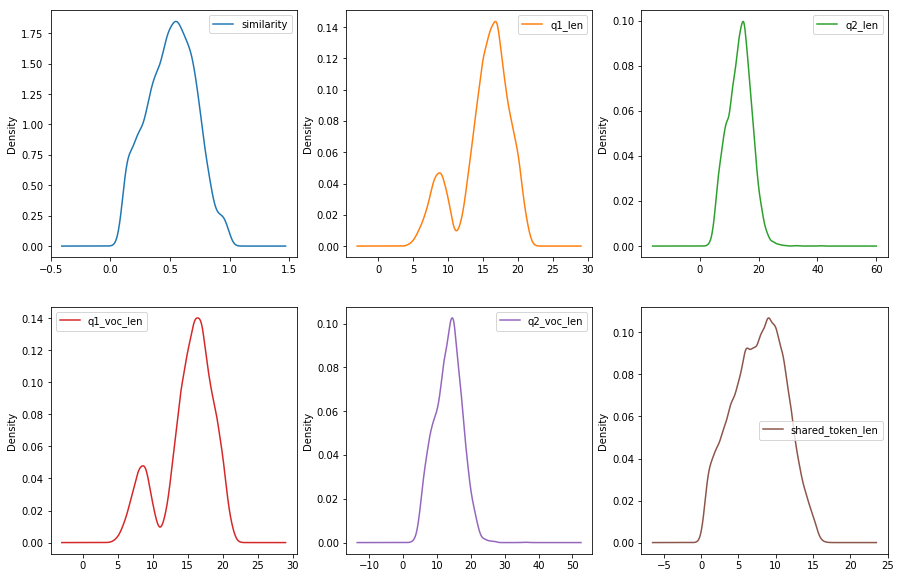

In [138]:

data_xgb[['similarity', 'q1_len', 'q2_len', 'q1_voc_len', 'q2_voc_len', 'shared_token_len']].plot(kind= 'density',
                                                                                                    figsize=(15, 10),
                                                                                                    subplots=True, layout=(2,3),
                                                                                                    sharex=False, sharey=False)
plt.show()

In [139]:
data_xgb_features = data_xgb[['similarity', 'q1_len', 'q2_len', 'q1_voc_len', 'q2_voc_len', 'shared_token_len']]

In [140]:
names = list(data_xgb_features.columns.values)

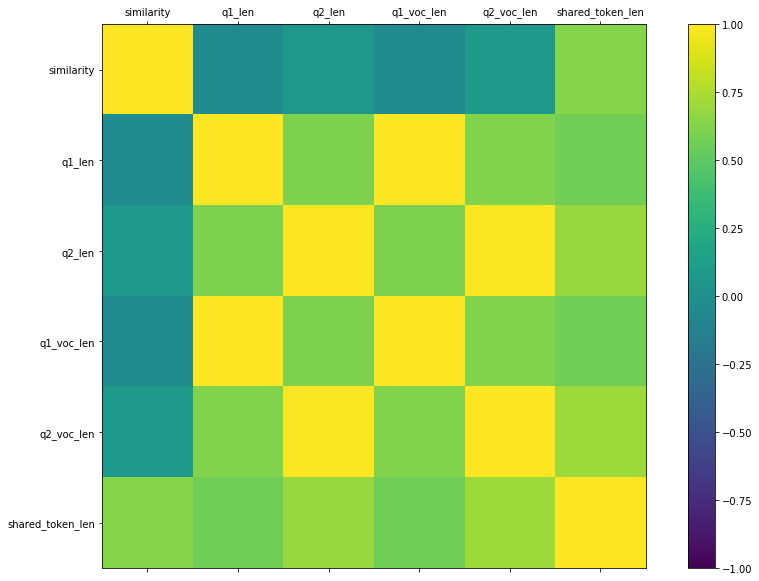

In [141]:

#correlation matrix
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(data_xgb_features.corr(),vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,6,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

In [142]:

# xgboost tree
xgb_model = XGBClassifier()
xgb_model.fit(data_xgb.drop('label',1), data_xgb.label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

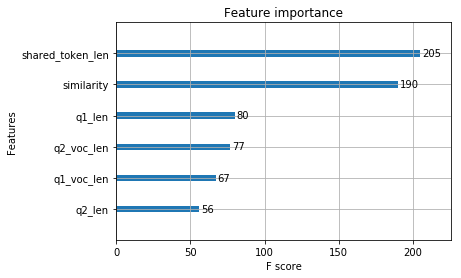

In [143]:
# todo importance figure
plot_importance(xgb_model)
plt.show()

In [144]:

# split the data into training and test dataset 
train_xgb, test_xgb = train_test_split(data_xgb, test_size=0.1, random_state=seed)

In [145]:

### save data for xgboost learning
train_xgb.to_pickle('xgb_train.pickle')
test_xgb.to_pickle('xgb_test.pickle')

In [146]:
import pandas as pd

In [147]:
def make_fbeta(threshold_shift):
    def fbeta(y_true, y_pred, beta=1):
        '''
        Compute fbeta score.
        :param y_true: y_true
        :param y_pred: predicted value
        :param threshold_shift: threshold
        :param beta: beta value
        :return: fbeta score
    
    '''
    # just in case of hipster activation at the final layer
        y_pred = K.clip(y_pred, 0, 1)
        y_true = K.clip(y_true, 0, 1)
    
    # shifting the prediction threshold from .5 if needed
        y_pred_bin = K.round(y_pred + threshold_shift)
    
        tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
        fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
        fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
    
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
    
        beta_squared = beta ** 2
        return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return fbeta

In [148]:
fbeta01 = make_fbeta(0.1)
fbeta02 = make_fbeta(0.2)
fbeta03 = make_fbeta(0.3)
fbeta04 = make_fbeta(0.4)
fbeta00 = make_fbeta(0.0)
fbeta_minus01 = make_fbeta(-0.1)
fbeta_minus02 = make_fbeta(-0.2)
fbeta_minus03 = make_fbeta(-0.3)
fbeta_minus04 = make_fbeta(-0.4)

In [149]:
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, merge, Reshape, Dropout
from keras.layers.merge import Dot
from keras.constraints import max_norm

FILEPATH = 'model.weights.best.hdf5'


class CnnModel(object):
    ''' Convolutional neural network model for question pair similarity '''
    
    def __init__(self, filter_size, strides, padding, embedding_len, activation,filters, k_initialization, b_initialization, input_shape, bias):
        # initialize the model
        self.filepath = FILEPATH
        self.cnn_model = self._build_model(filter_size, strides, padding, embedding_len, activation,filters, k_initialization,
                                           b_initialization, input_shape, bias)

    @classmethod
    def from_weights(cls, filepath, filter_size, strides, padding, embedding_len, activation,filters, k_initialization,
                                           b_initialization, input_shape, bias):
        
        self = cls(filter_size, strides, padding, embedding_len, activation, filters,
                                           k_initialization, b_initialization, input_shape, bias)
        self.filepath = filepath
        self.cnn_model.load_weights(filepath)
        return self
        

    def _convolutional_layer(self, filter_size, strides, padding, \
                            embedding_len, activation, \
                            bias, k_initialization, b_initialization, filters ):
        '''
        Defines a list of 2D convolution operations.
        :param filter_size: Integer, the dimensionality of the output space.
        :param strides: An integer or tuple/list of 2 integers, specifying the stride of the convolution.
        :param padding: Type of padding, one of  'valid' or 'same'.
        :param embedding_len: An integer, specifying the width of the 2D convolution window.
        :param activation: Activation function to use.
        :param bias: Boolean, whether the layer uses a bias vector.
        :param k_initialization: Initializer for the kernel weight matrix.
        :param b_initialization: Initializer for the bias vector.
        :param filters: A list of integer, specifying the different heights of the 2D convolution window.
        :return: A list of 2D convolution operations.
        '''
    
        cnns = [Conv2D(filters=filter_size, kernel_size=(filter_len, embedding_len), \
                       strides=strides, padding=padding, activation=activation,
                       use_bias=bias, kernel_initializer=k_initialization,
                       bias_initializer=b_initialization, kernel_constraint=max_norm(4.)) for filter_len in filters]
    
        return cnns
    

    def _input_sentence(self, shape):
        '''
        Defines the input shape.
        :param shape: Tuple of input shape
        :return: A tensor with shape (None, shape)
        '''
        return Input(shape=shape)
    
    def _cnn_sentences_layer(self, cnns, sentence):
        '''
        Computes a list of 2D convolution operations on an input sentence.
        :param cnns: a list of 2D convolution operations.
        :param sentence: input sentence.
        :return: A list of 2D convolution layer.
        '''
        return [cnn(sentence) for cnn in cnns]
    
    
    def _max_pool_sentences_layer(self, models, sentence_len, filters):
       '''
       Computes 2D max pooling operation.
       :param models: List of input tensors.
       :param sentence_len: Integer, the length of the sentence.
       :param filters: List of filters.
       :return: A list of tensor from the 2D max pooling operation.
       '''
       return [MaxPooling2D(pool_size=(sentence_len - filter_len + 1, 1))(model) for model, filter_len in zip(models, filters)]
    
    def _merge_concat_layer(self, model):
        '''
        Concatenates a list of tensors.
        :param model: Tensors to concatenate
        :return: A tensor from the concatenate operation.
        '''
        return  merge(model, mode='concat')
    
    def _merge_cosim_layer(self, model_1, model_2):
        '''
        Computes the cosine similarity between two tensors.
        :param model_1: The first tensor.
        :param model_2: The second tensor.
        :return: The cosine similarity value between model_1 and model_2.
        '''
        return Dot(axes=1, normalize=True)([model_1, model_2])
    
    def  _build_model(self,filter_size, strides, padding, embedding_len, activation,filters, k_initialization, b_initialization, input_shape, bias, dropout=0.3):
        '''
        Defines the convolutional neural network model.
        :param filter_size: Number of output.
        :param strides: Stride.
        :param padding: Padding value.
        :param embedding_len: Filter width.
        :param activation: Activation function.
        :param filters: List of integer - filters heights.
        :param k_initialization: Kernel initialization value.
        :param b_initialization: Bias initialization values
        :param input_shape: Input shape
        :param bias: Boolean, whether to use bias.
        :param dropout: Dropout value.
        :return: Convolutional neural network model.
        '''
        sentence_len = input_shape[0]
        
        # define input
        sentence_1_input = self._input_sentence(input_shape)
        sentence_2_input =self._input_sentence(input_shape)
    
        # convolutional layer
        cnns = self._convolutional_layer(filter_size, strides, padding, \
                            embedding_len, activation, \
                            bias, k_initialization, b_initialization, filters )
    
    
        ## sentence 1 convolutional layer
        sentence_1_cnn_layer = self._cnn_sentences_layer(cnns, sentence_1_input)
        ## add dropout regularization parameter
        sentence_1_cnn_layer = [Dropout(dropout)(cnn) for cnn in sentence_1_cnn_layer]
    
        ##sentence 2 convolutional layer
        sentence_2_cnn_layer = self._cnn_sentences_layer(cnns, sentence_2_input)
        ## add dropout regularization parameter
        sentence_2_cnn_layer = [Dropout(dropout)(cnn) for cnn in sentence_2_cnn_layer]
    
        # Max pooling layer
        ## sentence 1 max pooling layer
        sentence_1_max_pool = self._max_pool_sentences_layer(sentence_1_cnn_layer, sentence_len, filters)
    
        ## Sentence 2 max pooling layer
        sentence_2_max_pool = self._max_pool_sentences_layer(sentence_2_cnn_layer, sentence_len, filters)
    
        # concat layer
        ## Sentence 1 concat layer
        sentence_1_concat =  self._merge_concat_layer(sentence_1_max_pool)
    
        ## sentence 2 concat layer
        sentence_2_concat = self._merge_concat_layer(sentence_2_max_pool)
    
        # Flatten layer
        ## sentence 1 flatten layer
        sentence_1_flatten = Reshape((-1, ))(sentence_1_concat)
    
        ## Sentence 2 Flatten layer
        sentence_2_flatten = Reshape((-1, ))(sentence_2_concat)
    
        # Merge with cosine similarity layer
        dot = self._merge_cosim_layer(sentence_1_flatten, sentence_2_flatten)
        model = Model([sentence_1_input, sentence_2_input], [dot])
    
        return model
    
    def compile(self, loss, optimizer, metrics ):
        '''
        Configures the model for training.
        :param loss:  String (name of objective function) or objective function.
        :param optimizer: String (name of optimizer) or optimizer instance.
        :param metrics: list of metrics to be evaluated by the model during training and testing.
        '''
        self.cnn_model.compile(loss=loss, optimizer=optimizer,  metrics=metrics)

    def train(self, X_train, y_train, batch_size, epochs, validation_data, verbose=2, shuffle=True ):
        '''
        Trains the model for a fixed number of epochs.
        :param X_train: List of Numpy arrays of training data.
        :param y_train: List of Numpy arrays of target data.
        :param batch_size: Number of samples per gradient update.
        :param epochs: Number of epochs to train the model.
        :param validation_data: Tuple on which to evaluate the loss and any model metric at the end of each epoch.
        :param verbose: Verbosity mode - 0, 1, 2.
        :param shuffle: Boolean (True or False)- whether to shuffle the training data before each epoch.
        '''
        checkpointer = ModelCheckpoint(filepath=self.filepath, verbose=1,
                                   save_best_only=True)
        
        self.cnn_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                         validation_data=validation_data,
                         callbacks=[checkpointer],
                         verbose=verbose, shuffle=shuffle)
        
    def evaluate(self, X_test, y_test, verbose=0):
        '''
        Returns the loss value and metrics values for the model in test mode.
        :param X_test: List of Numpy array of test data.
        :param y_test: List of Numpy array of target data.
        :param verbose: Verbosity mode 0 or 1.
        :return: List of scalar - test loss and metrics values.
        '''
        return self.cnn_model.evaluate(X_test, y_test, verbose=verbose)
        
        
    def predict(self, x):
        '''
        Generates output predictions for the input samples.
        :param x: List of Numpy array of the input data.
        :return: Numpy array of predictions.
        '''
        return self.cnn_model.predict(x)
    
    def summary(self):
        '''
        Prints the summary representation of the model.
        '''
        self.cnn_model.summary()

In [150]:
import pandas as pd
from sklearn.model_selection import train_test_split

# define parameters
filter_size = 32
strides = (1, 1)
padding = 'VALID'
embedding_len = 100
activation = 'relu'
filters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
bias = True
sentence_len = 40
k_initialization = 'glorot_uniform'
b_initialization = 'zeros'
input_shape = (sentence_len, embedding_len, 1)
batch_size = 32
epochs = 100
seed = 10

# define metrics
acc = make_accuracy(0)
fbeta = make_fbeta(0)

FILE_PATH = 'cnn_train.pickle'
def main():
    # Prepare data
    data_cnn = pd.read_pickle(FILE_PATH)
    train, validation = train_test_split(data_cnn, test_size=0.1, random_state=seed)
    
    ## Traning data
    sentence_1_train = train.question1.tolist()
    sentence_2_train = train.question2.tolist()
    y_train = train.is_duplicate.tolist()
    question_1_train, question_2_train, y_train = reshape_data(sentence_1_train, sentence_2_train, y_train)
    
    ## Validation data
    sentence_1_validation = validation.question1.tolist()
    sentence_2_validation = validation.question2.tolist()
    y_validation = validation.is_duplicate.tolist()
    question_1_validation, question_2_validation, y_validation = reshape_data(sentence_1_validation,
                                                                              sentence_2_validation, y_validation)

    # Define the model
cnn_model = CnnModel(filter_size, strides, padding, embedding_len, activation, filters, k_initialization,
                         b_initialization, input_shape, bias)
cnn_model.summary()
cnn_model.compile(loss='mean_squared_error', optimizer='adam', metrics=[acc, fbeta])
    
    # Train the model
cnn_model.train([question_1_train, question_2_train], y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=([question_1_validation, question_2_validation], y_validation),
                    verbose=2, shuffle=True)
    




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40, 100, 1)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 40, 100, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 39, 1, 32)    6432        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 38, 1, 32)    9632        input_1[0][0]                    
          

NameError: name 'question_1_train' is not defined